# Classifier
ReLU activation, 4 layers, 100 neurons per layer
Validation score use ensemble of 10 models weighted by loss

### TODO:

- What metrics to use during training?
- Which plots are needed?


### Import modules

In [20]:
%matplotlib inline
from __future__ import division
import tensorflow as tf
import pandas as pd
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *
from keras.models import load_model

#dirLoc = '../Data/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss"
#dirLoc = '../Data_3Fold/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss_3Fold"
dirLoc = '../Data_SUSY/'
name = "weights/ReLU_Baseline_CLR_AsimovLoss_SUSY"

name_pretrain = name.replace('weights/', 'train_weights/PRETRAIN_')

## Prep SUSY data
    (analog zu Data_Import.py)

In [2]:
from Modules.Data_Import import prepareSample, getPreProcPipes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

nFolds = 2 # needed for cross-validation
# features same as Adam used
features = [
    'HT','MET','MT','MT2W','n_jet',
    'n_bjet','sel_lep_pt0','sel_lep_eta0','sel_lep_phi0',
    'selJet_phi0','selJet_pt0','selJet_eta0','selJet_m0',
    'selJet_phi1','selJet_pt1','selJet_eta1','selJet_m1',
    'selJet_phi2','selJet_pt2','selJet_eta2','selJet_m2',
]

df = pd.read_pickle('../../dfs/combinedleonid.pkl')
df.drop(columns=list(k for k in df.keys() if k not in features+['signal']), inplace=True)
df.rename(index=str, columns={"signal": "gen_target"}, inplace=True)
df['EventId'] = df.index.tolist()
df['gen_weight_original'] = 1.
df['gen_weight'] = 1.
df.fillna(0,inplace=True)

# 30% test, 16% validation, rest training
train, test = train_test_split(df, test_size=0.3, random_state=492)
train, val = train_test_split(train, test_size=0.2, random_state=492)

# a thing that's applied in Higgs analysis...
# convertData(trainingData, rotate, cartesian)
# convertData(test, rotate, cartesian)

data = {
    'train': train[features + ['gen_target', 'gen_weight', 'gen_weight_original']],
    'val': val[features + ['gen_target', 'gen_weight', 'gen_weight_original']],
    'test': test,
    'features': features
}

# rest copied from Modules.Data_Import.runDataImport:
inputPipe, _ = getPreProcPipes(normIn=True)
inputPipe.fit(data['train'][data['features']].values.astype('float32'))
with open(dirLoc + 'inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)

prepareSample(data['train'], 'train', inputPipe, False, nFolds, data['features'], dirLoc)
prepareSample(data['val']  , 'val', inputPipe, False, nFolds, data['features'], dirLoc)
prepareSample(data['test'] , 'test', inputPipe, False, nFolds, data['features'], dirLoc)

with open(dirLoc + 'features.pkl', 'wb') as fout:
    pickle.dump(data['features'], fout)

('Running', 'train')
('Saving fold:', 0, 'of', 560001, 'events')
('Saving fold:', 1, 'of', 559999, 'events')
('Running', 'val')
('Saving fold:', 0, 'of', 140001, 'events')
('Saving fold:', 1, 'of', 139999, 'events')
('Running', 'test')
('Saving fold:', 0, 'of', 300000, 'events')
('Saving fold:', 1, 'of', 300000, 'events')


## Options

In [21]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [22]:
nSplits = 1
patience = 50
maxEpochs = 200
preTrainMaxEpochs = 10

ensembleSize = 10
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelRelu', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

plot_while_training = True

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


# b = 100000  # test
# t = 250000  # training
# v = 450000  # test

# sig weight sum:  1383.97719575 in 550000
# bkg weight sum:  821999.696026 in 550000

# expected signal and background numbers
lumi=30.
s_exp=228.195*0.14*lumi #leonid's number
b_exp=844000.*8.2e-4*lumi #cross section of ttbar sample in fb times efficiency measured by Marco

print ('_S%.2e'%s_exp).replace('.', 'd').replace('+','p').replace('-','m')
print ('_B%.2e'%b_exp).replace('.', 'd').replace('+','p').replace('-','m')

new_loss_functions = get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp)

def plotLoss(history):
    val_loss = history['val_loss']
    plt.plot(history['val_train_loss'],label='train')
    plt.plot(val_loss,label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if max(val_loss) > 20*min(val_loss) and min(val_loss)>0:
        plt.yscale('log')
    plt.legend(loc='best')
#    plt.savefig(os.path.join(self.output,'lossEvolution.pdf'))
#    plt.clf()
    plt.show()

('\nTraining on', 21, 'features:', ['HT', 'MET', 'MT', 'MT2W', 'n_jet', 'n_bjet', 'sel_lep_pt0', 'sel_lep_eta0', 'sel_lep_phi0', 'selJet_phi0', 'selJet_pt0', 'selJet_eta0', 'selJet_m0', 'selJet_phi1', 'selJet_pt1', 'selJet_eta1', 'selJet_m1', 'selJet_phi2', 'selJet_pt2', 'selJet_eta2', 'selJet_m2'])
_S9d58ep02
_B2d08ep04


## Import data

In [23]:
trainData          = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r"))
trainDataTargetMod = BatchYielderTargetMod(h5py.File(dirLoc + 'train.hdf5', "r"))
nSplits = trainData.nFolds

## Train classifier
    (define model parameters + and train)

In [24]:

newModelArgs = modelParams.copy()
newModelArgs['compileArgs'] = compileArgs.copy()
newModelArgs['compileArgs']['lr'] = 1e-3   # learning rate

#loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S9d58ep02_B2d08ep04']
#loss = new_loss_functions['significanceLoss2Invert_S9d58ep02_B2d08ep04']
#newModelArgs['compileArgs']['loss'] = loss
newModelArgs['compileArgs']['do'] = 0.0  # drop-out
newModelArgs['compileArgs']['width'] = 23
newModelArgs['compileArgs']['depth'] = 1
trainParams['batch_size'] = 128

print('loss function is "%s"' % newModelArgs['compileArgs']['loss'])
print(trainParams['batch_size'])

loss function is "binary_crossentropy"
128


Training using weights
Running fold 1 / 2
.
1 New best found: 0.460447128718
.
2 New best found: 0.454409047747
.
3 New best found: 0.45062172198
.
4 New best found: 0.447576868743
.
5 New best found: 0.446062266536
.
6 New best found: 0.444438788616
.
7 New best found: 0.444268428587
.
8 New best found: 0.443045013243
.
9 New best found: 0.442271730717
.
10 New best found: 0.442048393678
...
13 New best found: 0.440961442893
...
16 New best found: 0.440221476328
..
18 New best found: 0.440169209625
..
20 New best found: 0.439819690311
..
22 New best found: 0.43896613269
...Score is: {'loss': 0.43896613268965323, 'AUC': 0.1248198303802146, 'cut': 0.0, 'wAUC': 0.1248198303802146, 'AMS': 0}


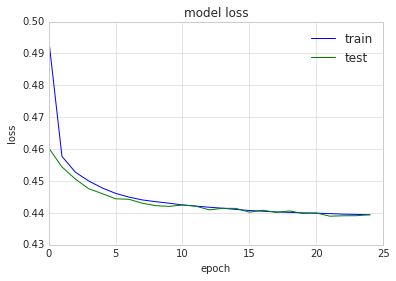

Fold took 350.908s

Running fold 2 / 2
.
1 New best found: 0.468391968711
.
2 New best found: 0.454726265069
.
3 New best found: 0.452173990681
.
4 New best found: 0.44993112495
.
5 New best found: 0.448581177624
.
6 New best found: 0.448135047247
.
7 New best found: 0.446636690423
..
9 New best found: 0.446199367132
.
10 New best found: 0.444736408785
..
12 New best found: 0.444704222437
..
14 New best found: 0.443801434372
.
15 New best found: 0.443752058089
.
16 New best found: 0.443099569898
..
18 New best found: 0.442808186414
..
20 New best found: 0.442271676038
.....Score is: {'loss': 0.4422716760380395, 'AUC': 0.12665012865388825, 'cut': 0.0, 'wAUC': 0.12665012865388825, 'AMS': 0}


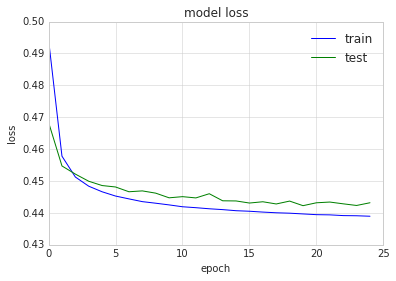

Fold took 347.147s


______________________________________
Training finished
Cross-validation took 698.125s 
Mean loss = 0.441 +- 0.001
Mean AUC = 0.1257 +- 0.0006
Mean cut = 0.0 +- 0.0
Mean wAUC = 0.1257 +- 0.0006
Mean AMS = 0.0 +- 0.0
______________________________________

Results saved in = train_weights/PRETRAIN_ReLU_Baseline_CLR_AsimovLoss_SUSY_model_step3p1.pkl


In [25]:
results, histories = batchTrainClassifier(trainData, 2, getModel, newModelArgs,
                                          trainParams, trainOnWeights=True, maxEpochs=25,
                                          cosAnnealMult=0, reduxDecay=-1,  # this line added
                                          patience=5, verbose=1, amsSize=-1, binary=True,
                                          #plotLR=plot_while_training, # plotMomentum=plot_while_training, 
                                          plot=plotLoss, 
                                          stopIfStallingTest=-1,
                                         )
n = name_pretrain+'_model_step3p1'
#model.save(n+'.h5')
with open(n+'.pkl', 'w') as f:
    pickle.dump((results, histories), f)
print('Results saved in = ' + n+'.pkl')

In [26]:
n = name_pretrain+'_model_step3p1'
#model = load_model(n+'.h5', custom_objects=new_loss_functions)
with open(n+'.pkl') as f:
    results, histories = pickle.load(f)

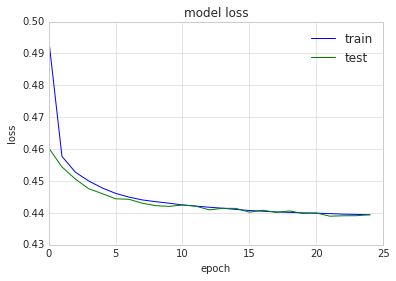

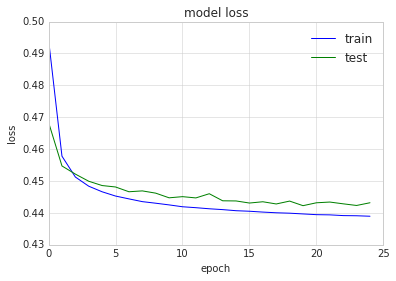

In [27]:
for i in range(len(histories)):
    plotLoss(histories[i])

## Construct ensemble

In [28]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:
    results = pickle.load(fin)

In [29]:
ensembleSize=2
ensemble, weights = assembleEnsemble(
    results, ensembleSize, ensembleMode, compileArgs, custom_objects=new_loss_functions)

('Choosing ensemble by', 'loss')
('Model', 0, 'is', 0, 'with', 'loss', '=', 0.43896613268965323)
('Model', 1, 'is', 1, 'with', 'loss', '=', 0.4422716760380395)


## Response on validation data with ensembling
(prediction with ensembling)

In [30]:
valData = BatchYielder(h5py.File(dirLoc + 'test.hdf5', "r+"))

In [31]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=2, verbose=1)

Predicting batch 1 out of 2
Prediction took 2.09281929334e-05s per sample

Predicting batch 2 out of 2
Prediction took 2.05494761467e-05s per sample

CPU times: user 15.4 s, sys: 1.11 s, total: 16.5 s
Wall time: 12.5 s


In [32]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.876429166396, weighted 0.876429166396


# Plotting

(600000, 'candidates loaded')


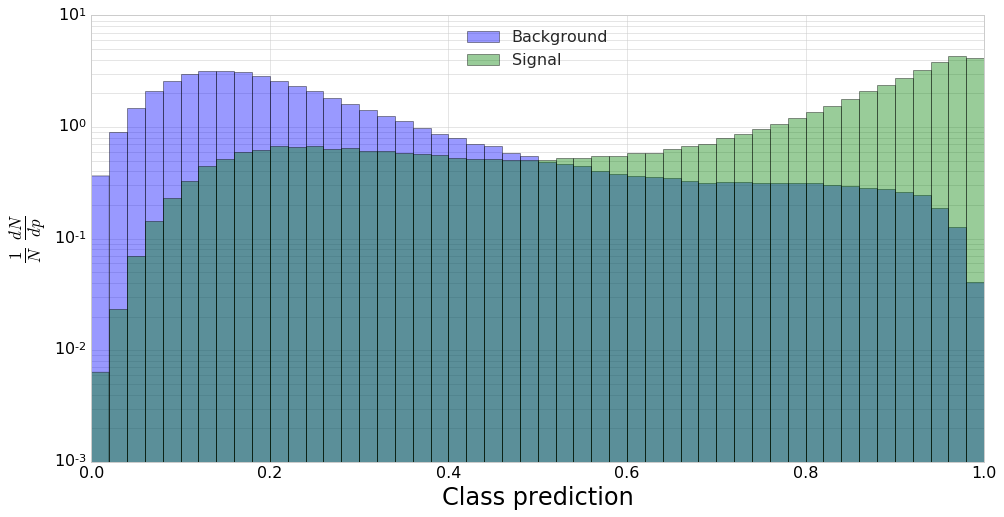

In [33]:
# TODO log-x
d = convertToDF(valData.source)

s_norm = s_exp/np.sum(d['gen_weight'][d['gen_target']==1])
b_norm = b_exp/np.sum(d['gen_weight'][d['gen_target']==0])

d['final_weight']                         = d['gen_weight']*s_norm
d.loc[d['gen_target']==0, 'final_weight'] = d['gen_weight']*b_norm

bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='final_weight')

0 ROC AUC: 0.876429166763


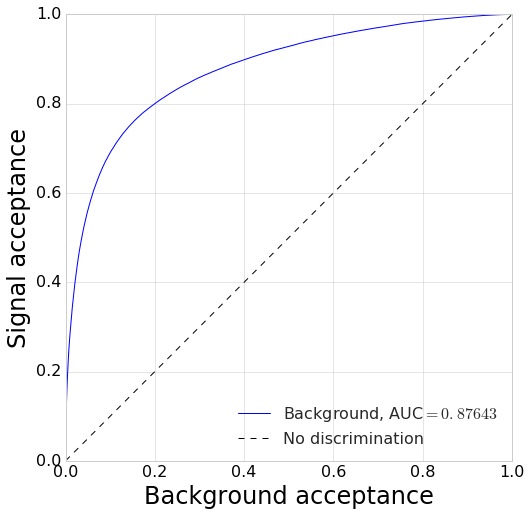

In [34]:
rocPlot([d], weightName='final_weight', labels=['Background', 'Signal'])

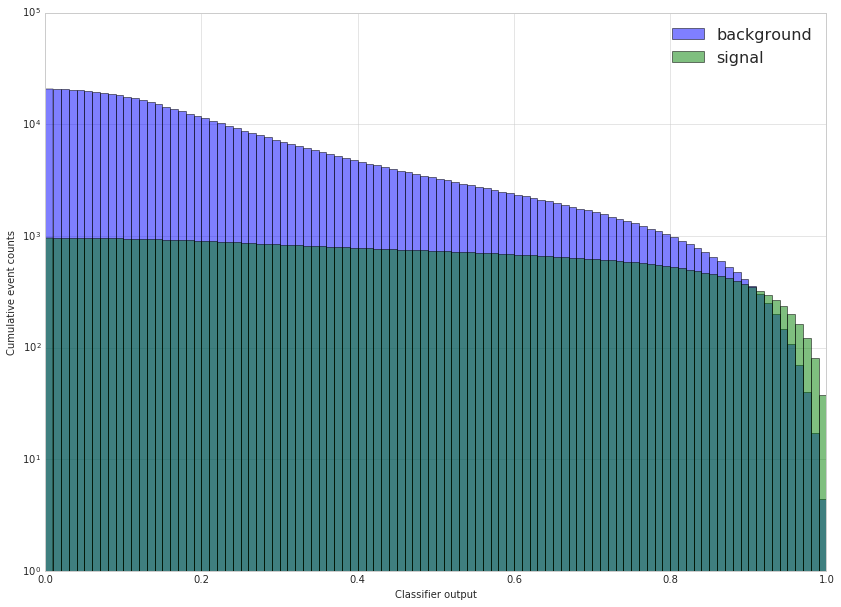

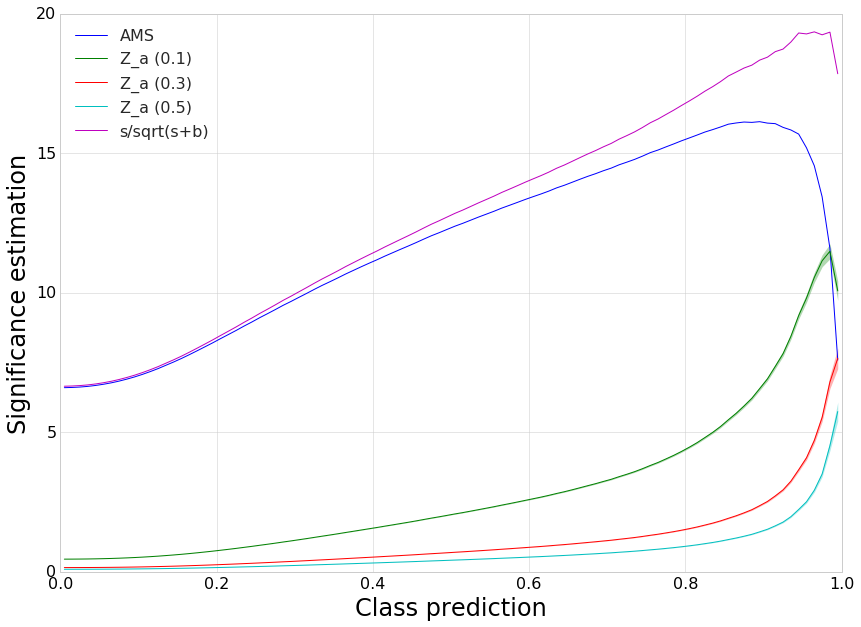

In [35]:
src = valData
#src = testData
from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), 
                        eZ_asimov(s,sqrt(s/s_norm)*s_norm,b,sqrt(b/b_norm)*b_norm,systematic))

h1 = plotSignificanceEstimate(
    d, 
    {
        #'s/sqrt(b)': lambda s,b: s/np.sqrt(b),
        's/sqrt(s+b)': lambda s,b: s/np.sqrt(b),
        'Z_a (0.5)': get_asimov(0.5),
        'Z_a (0.3)': get_asimov(0.3),
        'Z_a (0.1)': get_asimov(0.1),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='final_weight',
    figsize=(14, 10),
    nBins=100,
)

## Code dump

In [ ]:
def newGetModel(**modelArgs):
    new_model = getModel(**modelArgs)
    old_model =  load_model('PRETRAINGING.h5', custom_objects=new_loss_functions)
    new_model.set_weights(old_model.get_weights())
    return new_model